<a href="https://colab.research.google.com/github/SayatAbdikul/Food_classification/blob/main/food_classification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Importing PyTorch and setting up device-agnostic code

In [1]:
import torch
from torch import nn


In [2]:
device = "gpu" if torch.cuda.is_available() else "cpu"
device

'gpu'

# Get data

In [3]:
import requests
import zipfile
from pathlib import Path

data_path = Path("data/")
image_path = data_path / "pizza_steak_sushi"

if image_path.is_dir():
  print(f"{image_path} already exists, skipping download.")
else:
  print(f"{image_path} directory does not exist, creating one...")
  image_path.mkdir(parents=True, exist_ok=True)
# Downloading the data
with open(data_path / "pizza_steak_sushi.zip", "wb") as f:
  request = requests.get("https://github.com/mrdbourke/pytorch-deep-learning/raw/main/data/pizza_steak_sushi.zip")
  print("Downloading pizza, steak, sushi data...")
  f.write(request.content)

# Unzipping the downloaded file
with zipfile.ZipFile(data_path / "pizza_steak_sushi.zip", "r") as zip_ref:
  print("Unzipping pizza, steak, sushi data...")
  zip_ref.extractall(image_path)

data/pizza_steak_sushi directory does not exist, creating one...
Unzipping pizza, steak, sushi data...


# Data preparation and exploration

In [4]:
import os
def walk_through_dir(dir_path):
  for dirpath, dirnames, filenames in os.walk(dir_path):
    print(f"There are {len(dirnames)} directories and {len(filenames)} images in '{dirpath}'.")
walk_through_dir(image_path)

There are 2 directories and 0 images in 'data/pizza_steak_sushi'.
There are 3 directories and 0 images in 'data/pizza_steak_sushi/train'.
There are 0 directories and 78 images in 'data/pizza_steak_sushi/train/pizza'.
There are 0 directories and 72 images in 'data/pizza_steak_sushi/train/sushi'.
There are 0 directories and 75 images in 'data/pizza_steak_sushi/train/steak'.
There are 3 directories and 0 images in 'data/pizza_steak_sushi/test'.
There are 0 directories and 25 images in 'data/pizza_steak_sushi/test/pizza'.
There are 0 directories and 31 images in 'data/pizza_steak_sushi/test/sushi'.
There are 0 directories and 19 images in 'data/pizza_steak_sushi/test/steak'.


In [5]:
train_dir = image_path / "train"
test_dir = image_path / "test"
train_dir, test_dir

(PosixPath('data/pizza_steak_sushi/train'),
 PosixPath('data/pizza_steak_sushi/test'))

## Visualizing and image

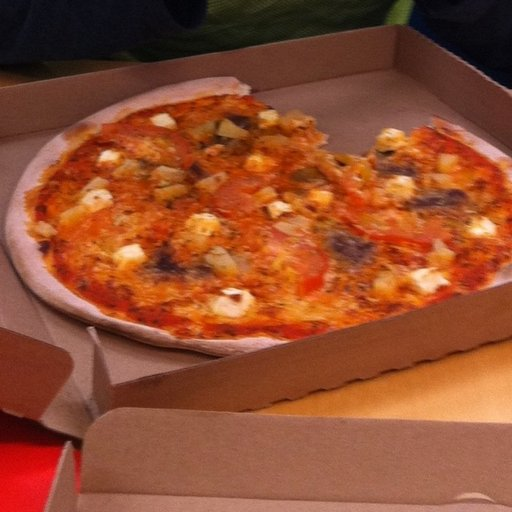

In [6]:
import random
from PIL import Image

random.seed(42)

image_path_list = list(image_path.glob("*/*/*.jpg"))

random_image_path = random.choice(image_path_list)

image_class = random_image_path.parent.stem

img = Image.open(random_image_path)
img


Text(0.5, 1.0, 'Image class: pizza')

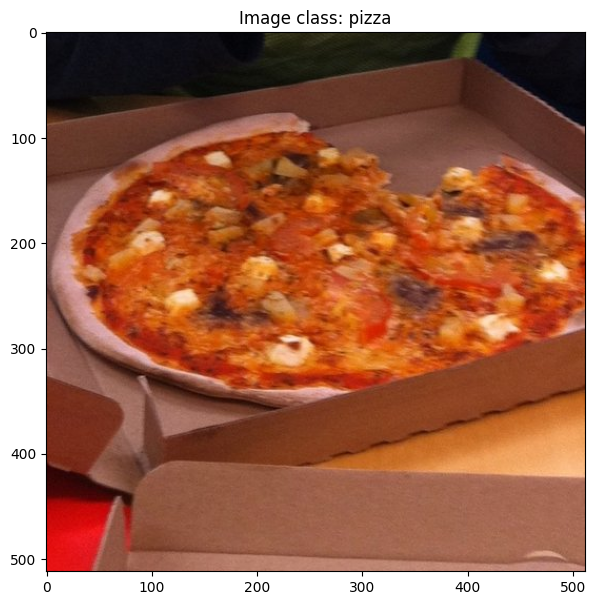

In [7]:
import numpy as np
import matplotlib.pyplot as plt
img_array = np.array(img)
plt.figure(figsize=(10, 7))
plt.imshow(img_array)
plt.title(f"Image class: {image_class}")

# Transforming data

In [8]:
import torch
from torch.utils.data import DataLoader
from torchvision import datasets, transforms

In [9]:
data_transform = transforms.Compose([
    transforms.Resize(size=(64, 64)),
    transforms.RandomHorizontalFlip(p=0.5),
    transforms.ToTensor()
  ]
  )
data_transform(img).shape

torch.Size([3, 64, 64])

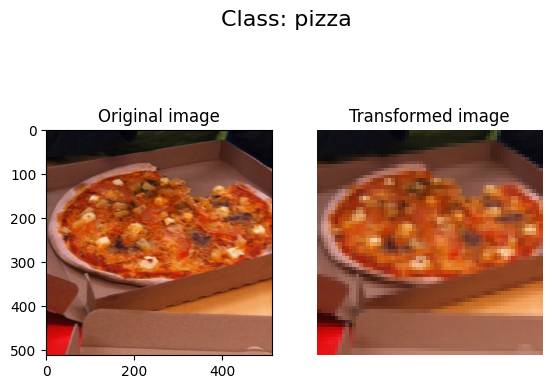

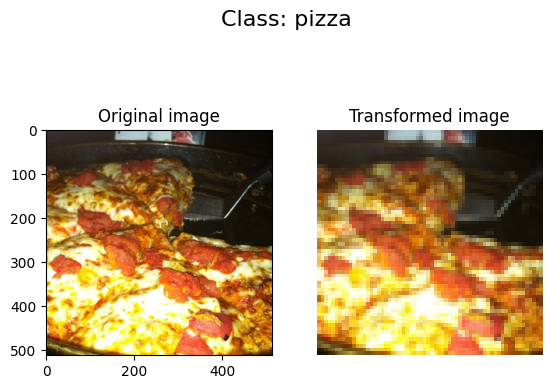

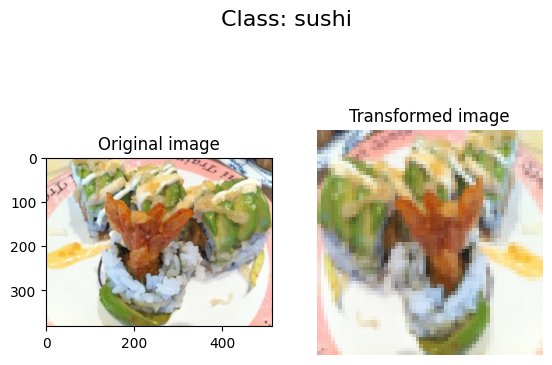

In [10]:
def plot_transformed_images(image_paths: list, transform, n=3, seed=None):
  if seed:
    random.seed(seed)
  random_image_paths = random.sample(image_paths, k=n)
  for image_path in random_image_paths:
    with Image.open(image_path) as f:
      fig, ax = plt.subplots(nrows=1, ncols=2)
      ax[0].imshow(f)
      ax[0].set_title(f"Original image")
      ax[0].axis = False
      transformed_image = transform(f).permute(1, 2, 0)
      ax[1].imshow(transformed_image)
      ax[1].set_title(f"Transformed image")
      ax[1].axis("off")
      fig.suptitle(f"Class: {image_path.parent.stem}", fontsize=16)
plot_transformed_images(image_path_list, data_transform, n=3, seed=42)


# Loading image data using ImageFolder

In [11]:
from torchvision import datasets
train_data = datasets.ImageFolder(root=train_dir, transform=data_transform, target_transform=None)
test_data = datasets.ImageFolder(root=test_dir, transform=data_transform, target_transform=None)


In [12]:
from torch.utils.data import DataLoader
BATCH_SIZE = 32
train_dataloader = DataLoader(dataset=train_data, batch_size=BATCH_SIZE,
                              num_workers=os.cpu_count(),
                              shuffle=True)
test_dataloader = DataLoader(dataset=test_data, batch_size=BATCH_SIZE, shuffle=False)



In [13]:
from torchvision import datasets
train_transform = transforms.Compose([
    transforms.Resize(size=(224, 224)),
    transforms.TrivialAugmentWide(num_magnitude_bins=31),
    transforms.ToTensor()
  ]
  )
test_transform = transforms.Compose([
    transforms.Resize(size=(224, 224)),
    transforms.ToTensor()
  ]
  )

In [14]:
image_path_list = list(image_path.glob("*/*/*.jpg"))
image_path_list[:5]

[PosixPath('data/pizza_steak_sushi/train/pizza/3109486.jpg'),
 PosixPath('data/pizza_steak_sushi/train/pizza/741883.jpg'),
 PosixPath('data/pizza_steak_sushi/train/pizza/739735.jpg'),
 PosixPath('data/pizza_steak_sushi/train/pizza/1285298.jpg'),
 PosixPath('data/pizza_steak_sushi/train/pizza/667309.jpg')]

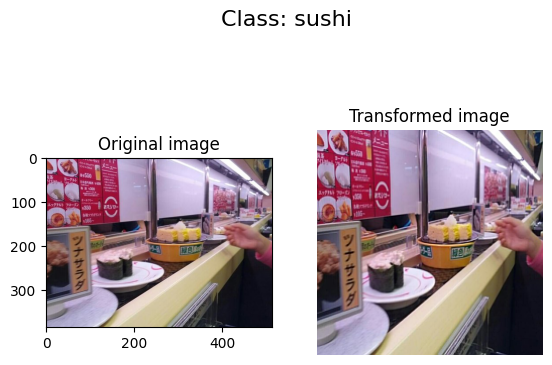

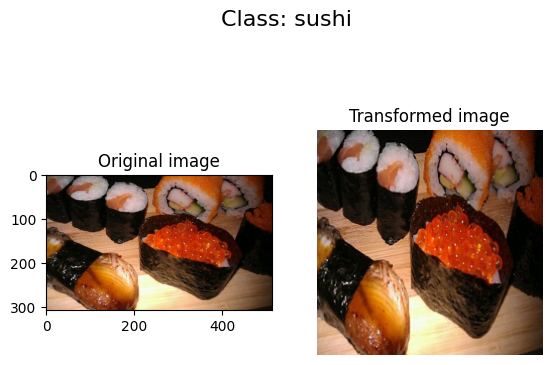

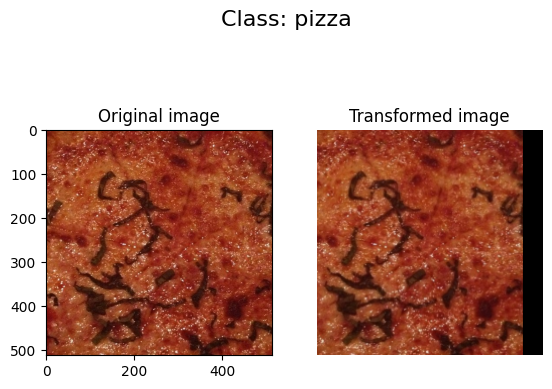

In [15]:
plot_transformed_images(image_path_list, train_transform, n=3, seed=None)

# Model 0: TinyVGG without data augmentation

## Transform

In [18]:
simple_transform = transforms.Compose(
    [
        transforms.Resize(size=(64, 64)),
        transforms.ToTensor()
    ]
)

In [19]:
from torchvision import datasets
train_data_simple = datasets.ImageFolder(root=train_dir, transform=simple_transform, target_transform=None)
test_data_simple = datasets.ImageFolder(root=test_dir, transform=simple_transform, target_transform=None)

import os
from torch.utils.data import DataLoader
BATCH_SIZE = 32
NUM_WORKERS = os.cpu_count()
train_loader = DataLoader(train_data_simple, batch_size=BATCH_SIZE,
                          num_workers=NUM_WORKERS,
                          shuffle=True)
test_loader = DataLoader(test_data_simple, batch_size=BATCH_SIZE,
                         num_workers=NUM_WORKERS,
                         shuffle=True)

## Model